# Q2: Clustering
###Member Segmentation for Care Management

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score

import umap

sns.set(style="whitegrid", font_scale=1.1)
np.random.seed(42)

# Data

- Load cleaned dataset
- Remove stray “Unnamed: 0”-type columns left over from CSV exports
- Filter Age for Adult Population
- Log-Transform Skewed Healthcare Variables

In [2]:
# Load data and cleaning
df = pd.read_csv("cleaned_medical_insurance.csv")
df = df.loc[:, ~df.columns.str.contains("Unnamed")]

# Filter Age
df = df[(df['age'] >= 18) & (df['age'] <= 65)].copy()
print("Filtered age range:", df['age'].min(), df['age'].max())
print("Remaining members:", df.shape[0])

Filtered age range: 18 65
Remaining members: 83827


In [3]:
# log-trasnform highly skewed continous variables
log_cols = [
    'annual_medical_cost','total_claims_paid',
    'visits_last_year','hospitalizations_last_3yrs',
    'days_hospitalized_last_3yrs','avg_claim_amount',
    'monthly_premium','annual_premium','claims_count'
]

for col in log_cols:
    df[col] = np.log1p(df[col])

#PCA

First perform Standardization (**critical** before PCA), because features must be on the same scale.

PCA Dimensionality Reduction allows for:
- reduces hundreds of columns (due to one-hot encoding) → 15 orthogonal components
- Removes noise and multicollinearity
- Makes clusters easier to find

In [4]:
from sklearn.preprocessing import StandardScaler

X = df
# One-Hot Encode All Categorical Variables
X = pd.get_dummies(X, drop_first=True)

# Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [5]:
# PCA Dimensionality Reduction
from sklearn.decomposition import PCA
pca = PCA(n_components=15, whiten=True, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# K-Means Clustering

/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


Text(0.5, 1.0, 'KMeans Clusters (k=6)')

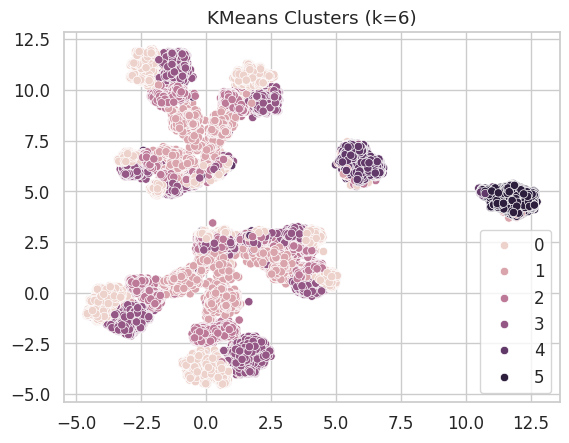

In [6]:
# K-Means Clustering
kmeans = KMeans(n_clusters=6, random_state=42, n_init=20)
labels_km = kmeans.fit_predict(X_pca)

#UMAP 2d Visualization
import umap
um = umap.UMAP(n_neighbors=40, min_dist=0.05, random_state=42)
emb = um.fit_transform(X_pca)

sns.scatterplot(x=emb[:,0], y=emb[:,1], hue=labels_km)
plt.title("KMeans Clusters (k=6)")


# GMM Clustering

Text(0.5, 1.0, 'GMM Clusters (k=6)')

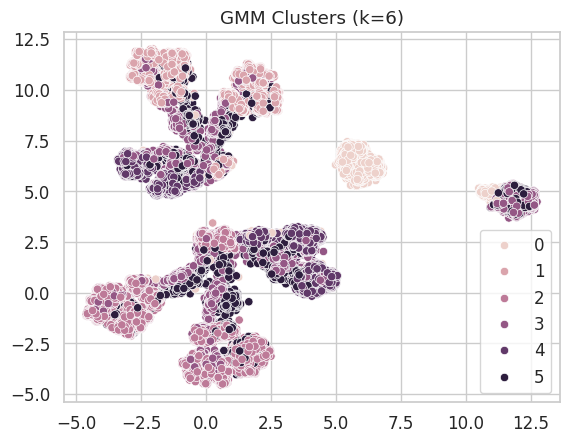

In [7]:
# GMM Clustering
from sklearn.mixture import GaussianMixture
gmm = GaussianMixture(n_components=6, random_state=42, covariance_type='full')
labels_gmm = gmm.fit_predict(X_pca)

sns.scatterplot(x=emb[:,0], y=emb[:,1], hue=labels_gmm)
plt.title("GMM Clusters (k=6)")

# Diagnostics

- scree plot
- PCA Explained Variance
- PCA Loadings
- Silhouette Score
- Cluster Labels

In [8]:
# Replace NaNa and Recompute PCA (for Scree Plot)
X_scaled = np.nan_to_num(X_scaled, nan=0.0)
pca = PCA(n_components=12, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# PCA Explained Variance
expl_var = pca.explained_variance_ratio_
pd.DataFrame({
    "PC": [f"PC{i+1}" for i in range(len(expl_var))],
    "Variance": expl_var,
    "Percent": expl_var * 100,
    "Cumulative": expl_var.cumsum() * 100
})


,PC,Variance,Percent,Cumulative
0,PC1,0.082956,8.295640,8.295640
1,PC2,0.036282,3.628226,11.923867
2,PC3,0.033923,3.392294,15.316160
3,PC4,0.031705,3.170455,18.486615
4,PC5,0.027798,2.779834,21.266449
5,PC6,0.025545,2.554481,23.820930
6,PC7,0.023434,2.343370,26.164300
7,PC8,0.022721,2.272120,28.436420
8,PC9,0.022131,2.213090,30.649510
9,PC10,0.021075,2.107544,32.757055


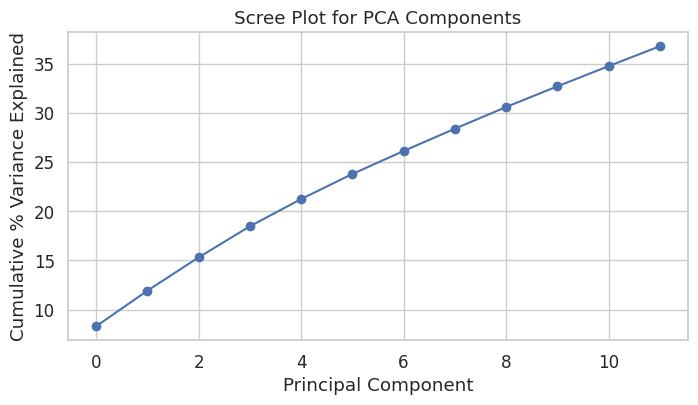

In [9]:
# Scree Plot
plt.figure(figsize=(8,4))
plt.plot(np.cumsum(pca.explained_variance_ratio_)*100, marker='o')
plt.xlabel("Principal Component")
plt.ylabel("Cumulative % Variance Explained")
plt.title("Scree Plot for PCA Components")
plt.grid(True)


In [10]:
# PCA Loadings (Featire Importance per PC)
loadings = pd.DataFrame(
    pca.components_.T,
    columns=[f"PC{i+1}" for i in range(pca.n_components_)],
    index=X.columns
)

loadings.abs().nlargest(10, "PC1")


,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12
chronic_count,0.324782,0.097171,0.143472,0.004352,0.116733,0.131674,0.007457,0.015049,0.007925,0.003312,0.164103,0.037107
risk_score,0.316195,0.052991,0.290030,0.013224,0.017925,0.050004,0.001978,0.030313,0.010795,0.005799,0.030796,0.005230
is_high_risk,0.274674,0.053353,0.258037,0.014506,0.005632,0.070082,0.002666,0.036482,0.005389,0.008897,0.047868,0.009398
annual_medical_cost,0.260160,0.321903,0.072626,0.011761,0.279278,0.022126,0.013278,0.137420,0.018665,0.002409,0.040015,0.000341
total_claims_paid,0.259881,0.220479,0.381718,0.027999,0.018767,0.116760,0.007228,0.016959,0.008584,0.007469,0.093748,0.019882
claims_count,0.259359,0.264860,0.313718,0.027913,0.043473,0.082550,0.005764,0.038230,0.008895,0.003319,0.056411,0.010593
annual_premium,0.258547,0.340636,0.079258,0.010232,0.295944,0.025467,0.015610,0.160764,0.019328,0.005799,0.053131,0.004263
monthly_premium,0.258376,0.340661,0.079306,0.010224,0.295707,0.025445,0.015612,0.160755,0.019297,0.005800,0.053092,0.004264
avg_claim_amount,0.242891,0.204467,0.383293,0.027037,0.030183,0.122177,0.007572,0.012986,0.008417,0.008347,0.101697,0.021756
visits_last_year,0.242699,0.220292,0.254570,0.024953,0.036575,0.062387,0.002803,0.025928,0.007891,0.002902,0.030394,0.005486


In [11]:
# Silhouette Score
sil = silhouette_score(X_pca, labels_km)
print("Silhouette Score:", sil)


Silhouette Score: 0.08508780628338988


In [12]:
# Add cluster labels
df['cluster_gmm'] = labels_gmm  # or labels_km

# Separate numeric & categorical
num_cols = df.select_dtypes(include=['int64','float64']).columns
cat_cols = df.select_dtypes(include=['object','category','bool']).columns

# Numerical summaries
print("\n===== NUMERIC PROFILE BY CLUSTER =====")
display(df.groupby('cluster_gmm')[num_cols].mean().round(2))

# Categorical summaries (proportions)
print("\n===== CATEGORICAL PROFILE BY CLUSTER =====")
for col in cat_cols:
    print(f"\n--- {col} distribution ---")
    display(df.groupby('cluster_gmm')[col].value_counts(normalize=True).mul(100).round(1))



===== NUMERIC PROFILE BY CLUSTER =====


,age,income,household_size,dependents,bmi,visits_last_year,hospitalizations_last_3yrs,days_hospitalized_last_3yrs,medication_count,systolic_bp,...,arthritis,mental_health,proc_imaging_count,proc_surgery_count,proc_physio_count,proc_consult_count,proc_lab_count,is_high_risk,had_major_procedure,cluster_gmm
cluster_gmm,,,,,,,,,,,,,,,,,,,,,
0,44.86,48912.52,2.43,0.91,26.98,0.95,0.71,1.53,1.31,116.86,...,0.12,0.15,0.53,0.18,0.53,0.53,0.53,0.35,0.63,0.0
1,44.12,49881.16,2.42,0.89,26.99,0.42,0.00,0.00,0.98,114.19,...,0.05,0.06,0.46,0.08,0.44,0.45,0.44,0.10,0.07,1.0
2,44.82,50010.54,2.43,0.90,27.00,1.16,0.00,0.00,1.24,117.23,...,0.13,0.15,0.51,0.15,0.51,0.52,0.51,0.26,0.13,2.0
3,45.15,49185.37,2.90,0.90,27.00,0.95,0.00,0.00,1.33,116.59,...,0.11,0.13,0.53,0.22,0.53,0.53,0.53,0.46,0.16,3.0
4,44.59,50201.23,2.43,0.91,26.93,0.88,0.00,0.00,1.15,116.28,...,0.09,0.12,0.48,0.11,0.49,0.48,0.49,0.20,0.11,4.0
5,45.00,50403.09,1.90,0.90,27.03,0.94,0.00,0.00,1.30,116.23,...,0.11,0.13,0.54,0.18,0.53,0.52,0.53,0.45,0.14,5.0



===== CATEGORICAL PROFILE BY CLUSTER =====

--- sex distribution ---


cluster_gmm  sex   
0            Male      50.1
             Female    48.0
             Other      1.8
1            Female    49.1
             Male      48.8
             Other      2.1
2            Male      49.0
             Female    48.9
             Other      2.1
3            Female    49.9
             Male      48.1
             Other      2.0
4            Female    49.4
             Male      48.5
             Other      2.1
5            Female    50.1
             Male      48.0
             Other      1.9
Name: proportion, dtype: float64


--- region distribution ---


cluster_gmm  region 
0            South       29.1
             North       21.8
             East        19.5
             West        18.0
             Central     11.6
1            North       30.7
             East        28.0
             West        25.1
             Central     16.3
2            North       30.7
             East        28.3
             West        24.5
             Central     16.6
3            South       27.1
             North       22.4
             East        19.5
             West        17.7
             Central     13.3
4            South      100.0
5            South       27.9
             North       21.9
             East        20.1
             West        17.9
             Central     12.2
Name: proportion, dtype: float64


--- urban_rural distribution ---


cluster_gmm  urban_rural
0            Urban          60.7
             Suburban       25.0
             Rural          14.3
1            Urban          60.5
             Suburban       24.6
             Rural          14.9
2            Urban          60.5
             Suburban       24.7
             Rural          14.9
3            Urban          59.2
             Suburban       25.8
             Rural          15.0
4            Urban          60.1
             Suburban       24.9
             Rural          15.0
5            Urban          59.5
             Suburban       25.2
             Rural          15.3
Name: proportion, dtype: float64


--- education distribution ---


cluster_gmm  education   
0            Bachelors       27.3
             HS              25.6
             Some College    24.7
             Masters         14.0
             No HS            5.4
             Doctorate        3.1
1            Bachelors       28.1
             Some College    25.6
             HS              24.4
             Masters         14.0
             No HS            5.1
             Doctorate        2.8
2            Bachelors       28.1
             Some College    25.1
             HS              24.9
             Masters         14.0
             No HS            5.1
             Doctorate        2.8
3            Bachelors       27.6
             Some College    25.6
             HS              24.8
             Masters         13.9
             No HS            5.1
             Doctorate        3.1
4            Bachelors       28.0
             HS              25.2
             Some College    25.1
             Masters         13.8
             No HS            5.0
             Doctorate        3.0
5            Bachelors       28.6
             HS              25.0
             Some College    24.7
             Masters         13.8
             No HS            4.7
             Doctorate        3.1
Name: proportion, dtype: float64


--- marital_status distribution ---


cluster_gmm  marital_status
0            Married            51.9
             Single             36.9
             Divorced            7.0
             Widowed             4.2
1            Married            52.4
             Single             36.3
             Divorced            7.1
             Widowed             4.1
2            Married            52.8
             Single             35.9
             Divorced            7.1
             Widowed             4.3
3            Married           100.0
4            Married            52.5
             Single             36.4
             Divorced            7.4
             Widowed             3.8
5            Single             77.0
             Divorced           14.5
             Widowed             8.5
             Married             0.0
Name: proportion, dtype: float64


--- employment_status distribution ---


cluster_gmm  employment_status
0            Employed             55.0
             Retired              20.1
             Unemployed           13.1
             Self-employed        11.8
1            Employed             55.3
             Retired              19.9
             Unemployed           12.7
             Self-employed        12.1
2            Employed             55.4
             Retired              19.9
             Unemployed           13.0
             Self-employed        11.7
3            Employed             55.6
             Retired              20.0
             Unemployed           12.7
             Self-employed        11.7
4            Employed             55.2
             Retired              19.8
             Unemployed           13.0
             Self-employed        12.0
5            Employed             55.4
             Retired              19.4
             Unemployed           13.1
             Self-employed        12.1
Name: proportion, dtype: float64


--- smoker distribution ---


cluster_gmm  smoker 
0            Never       69.5
             Former      18.4
             Current     12.2
1            Never      100.0
2            Never      100.0
3            Former      47.5
             Current     32.2
             Never       20.3
4            Never      100.0
5            Former      51.0
             Current     33.0
             Never       16.0
Name: proportion, dtype: float64


--- alcohol_freq distribution ---


cluster_gmm  alcohol_freq
0            Occasional      44.0
             Non-drinker     30.8
             Weekly          20.1
             Daily            5.1
1            Occasional      45.7
             Non-drinker     30.9
             Weekly          18.5
             Daily            5.0
2            Occasional      45.0
             Non-drinker     30.2
             Weekly          19.6
             Daily            5.2
3            Occasional      45.0
             Non-drinker     29.0
             Weekly          20.8
             Daily            5.2
4            Occasional      45.2
             Non-drinker     30.2
             Weekly          19.7
             Daily            4.8
5            Occasional      44.6
             Non-drinker     30.6
             Weekly          19.9
             Daily            4.8
Name: proportion, dtype: float64


--- plan_type distribution ---


cluster_gmm  plan_type
0            PPO          36.2
             HMO          34.1
             EPO          15.2
             POS          14.5
1            PPO          35.1
             HMO          34.9
             EPO          15.3
             POS          14.7
2            PPO          35.1
             HMO          34.6
             EPO          15.2
             POS          15.1
3            PPO          34.6
             HMO          34.5
             POS          16.0
             EPO          14.8
4            HMO          35.7
             PPO          35.3
             EPO          15.0
             POS          13.9
5            PPO          35.3
             HMO          34.5
             EPO          15.1
             POS          15.0
Name: proportion, dtype: float64


--- network_tier distribution ---


cluster_gmm  network_tier
0            Silver          40.3
             Bronze          30.1
             Gold            19.8
             Platinum         9.9
1            Silver          39.5
             Bronze          30.7
             Gold            20.1
             Platinum         9.8
2            Silver          40.0
             Bronze          30.3
             Gold            19.8
             Platinum         9.9
3            Silver          40.6
             Bronze          29.2
             Gold            20.0
             Platinum        10.2
4            Silver          40.3
             Bronze          30.0
             Gold            19.9
             Platinum         9.7
5            Silver          40.0
             Bronze          29.5
             Gold            20.1
             Platinum        10.5
Name: proportion, dtype: float64